In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Model, load_model 
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
#importing data
X = np.load("data/landmark_arrays/sequences.npy")
y = np.load("data/landmark_arrays/labels.npy")

In [4]:
#try scaling for real time performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (520, 30, 1662)
X_test:  (130, 30, 1662)


In [5]:
#Shuffling dataset between epochs
buffer_size = 10000
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

In [6]:
#callbacks
log_dir = os.path.join('logs')
checkpoint_dir = os.path.join('logs/checkpoints/')
tb_callback = TensorBoard(log_dir = log_dir)
reduceLR_callback = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.8, cooldown = 10, min_lr = 1e-5)
checkpoint_callback = ModelCheckpoint(filepath = checkpoint_dir, monitor = 'val_accuracy', save_best_only = True, save_weights_only = True, initial_value_threshold = 0.9)

In [7]:
#LSTM model:
i = Input(shape = X_train[0].shape)
#choose b/w ReLU and tanh activation
x = LSTM(128, return_sequences = True)(i) 
x = GlobalMaxPooling1D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation = 'relu')(x)
x = Dense(len(list(set(y))), activation = 'softmax')(x)

LSTM_model = Model(i, x)

In [8]:
LSTM_model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
r = LSTM_model.fit(
    train_dataset, 
    validation_data = test_dataset, 
    epochs = 800,
    callbacks = [tb_callback, reduceLR_callback, checkpoint_callback]
    )
LSTM_model.load_weights(checkpoint_dir)

Epoch 1/800
17/17 [==============================] - 7s 54ms/step - loss: 2.5987 - accuracy: 0.0827 - val_loss: 2.5571 - val_accuracy: 0.0769 - lr: 0.0010
Epoch 2/800
17/17 [==============================] - 0s 22ms/step - loss: 2.5324 - accuracy: 0.0885 - val_loss: 2.5270 - val_accuracy: 0.1615 - lr: 0.0010
Epoch 3/800
17/17 [==============================] - 0s 23ms/step - loss: 2.5178 - accuracy: 0.1538 - val_loss: 2.4940 - val_accuracy: 0.1154 - lr: 0.0010
Epoch 4/800
17/17 [==============================] - 0s 21ms/step - loss: 2.4458 - accuracy: 0.1635 - val_loss: 2.4394 - val_accuracy: 0.1846 - lr: 0.0010
Epoch 5/800
17/17 [==============================] - 0s 21ms/step - loss: 2.3623 - accuracy: 0.2019 - val_loss: 2.3855 - val_accuracy: 0.2231 - lr: 0.0010
Epoch 6/800
17/17 [==============================] - 0s 22ms/step - loss: 2.2860 - accuracy: 0.2115 - val_loss: 2.3469 - val_accuracy: 0.2154 - lr: 0.0010
Epoch 7/800
17/17 [==============================] - 0s 22ms/step - lo

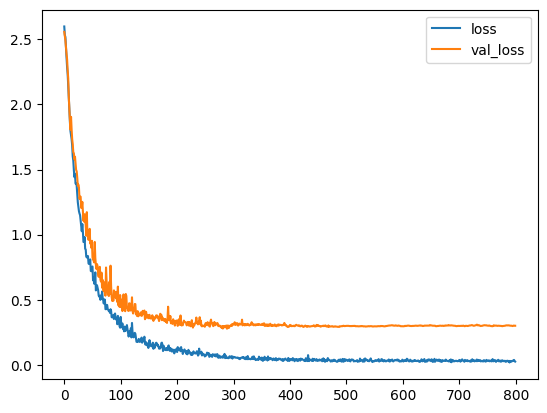

In [9]:
#loss:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show() 

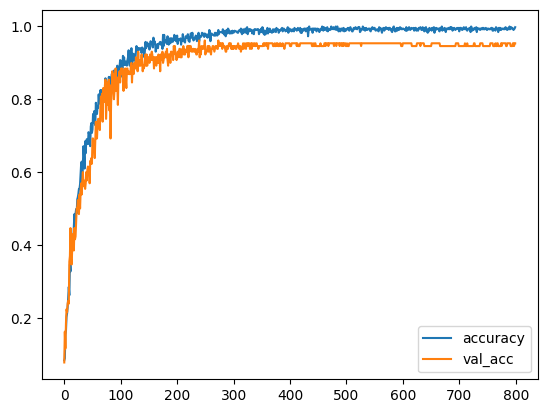

In [10]:
#accuracy:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.show() 

In [11]:
LSTM_model.evaluate(test_dataset)

5/5 [==============================] - 0s 10ms/step - loss: 0.3304 - accuracy: 0.9615


[0.33038169145584106, 0.9615384340286255]

In [12]:
LSTM_model.save('models/lstm/LSTM_model.h5')

In [13]:
actions = np.array(['kebab', 'chicken', 'beef', 'impossible', 'burrito', 'veggie', 'quesadilla', 'hummus', 'guacamole', 'cheese', 'bowl', 'salmon', 'tacos'])
model = load_model("models/LSTM_model.h5")

In [14]:
result = model.predict(X_test)
yhat = []
for i in range(len(result)):
    yhat.append(np.argmax(result[i]))
print(multilabel_confusion_matrix(y_test, yhat))
print(accuracy_score(y_test, yhat))

5/5 [==============================] - 0s 22ms/step
[[[119   1]
  [  1   9]]

 [[119   1]
  [  0  10]]

 [[120   0]
  [  0  10]]

 [[120   0]
  [  1   9]]

 [[120   0]
  [  0  10]]

 [[120   0]
  [  1   9]]

 [[120   0]
  [  1   9]]

 [[118   2]
  [  0  10]]

 [[119   1]
  [  0  10]]

 [[120   0]
  [  0  10]]

 [[120   0]
  [  0  10]]

 [[120   0]
  [  0  10]]

 [[120   0]
  [  1   9]]]
0.9615384615384616
